In [1]:
from configs.default import get_default_config
from models import build_model
import torch

cfg = get_default_config()
cfg.merge_from_file('./configs/clip_multiview_mlm.yaml')
cfg.MODEL.NUM_CLASS = 11003

class args:
    resume = True
    use_cuda = True

model = build_model(cfg, args)

/home/server1-ailab/miniconda3/envs/bach_pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load pretrained ViT-B/16 CLIP model with model config: {'embed_dim': 512, 'image_resolution': [384, 128], 'vision_layers': 12, 'vision_width': 768, 'vision_patch_size': 16, 'context_length': 77, 'vocab_size': 49408, 'transformer_width': 512, 'transformer_heads': 8, 'transformer_layers': 12, 'stride_size': 16}
LOAD MODEL SUCCESSFULLY
Resized position embedding from size:torch.Size([1, 197, 768]) to size: torch.Size([1, 193, 768]) with height:24 width: 8
RESTORE FROM  ./logs/clip_multiview_mlm/checkpoint_mlm_74-042.pth
Loaded checkpoint from ./logs/clip_multiview_mlm/checkpoint_mlm_74-042.pth


In [2]:
from datasets.cuhkpedes_dataset import CUHKPEDESDatasetV3
from preprocessing.transforms import build_transforms
from datasets.build import build_dataloader


train_loader, _, _, _ = build_dataloader(cfg)


In [3]:
from utils.simple_tokenizer import SimpleTokenizer

tokenizer = SimpleTokenizer(bpe_path='./data/bpe_simple_vocab_16e6.txt.gz')

In [4]:
sample = train_loader.dataset.__getitem__(845)

In [5]:
image = sample['images'][0]

In [6]:
from models.multi_clip_mlm import MAEDecoder

decoder = MAEDecoder(cfg, model.base_model.visual).to(torch.device('cuda'))

In [7]:
image = image.unsqueeze(0)

In [8]:
text_embs = torch.randn(1, 77, 512)

In [9]:
imgs, pred, mask = decoder.forward(image.cuda(), 0.5, text_embs.cuda())

torch.Size([1, 193, 512])
torch.Size([1, 193, 512])


In [10]:
patched_img = decoder.patchify(imgs)

In [11]:
mask = mask.unsqueeze(2).expand(-1, -1, 768)
mask = mask == 0

In [89]:
masked_img = patched_img * mask

In [90]:
import matplotlib.pyplot as plt
mask_image = masked_img[0].cpu().numpy()

In [91]:
def unpatchify(x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = 16
    w = 8
    h = 24
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, w * p))
    return imgs

In [92]:
mask_img = unpatchify(masked_img)

In [93]:
mask_img[mask_img == 0] = 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


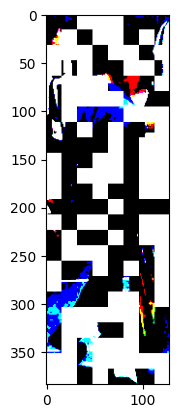

In [94]:
plt.imshow(mask_img[0].permute(1, 2, 0).cpu().numpy() * 255)

In [95]:
pred_img = unpatchify(pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


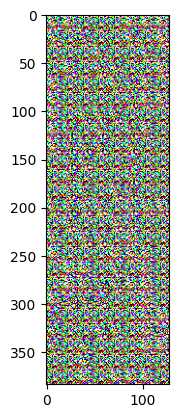

In [98]:
plt.imshow(pred_img[0].permute(1, 2, 0).detach().cpu().numpy() * 255)

In [ ]:
print(imgs.shape, mask.shape, token.shape)

torch.Size([3, 288, 128]) torch.Size([3, 384]) torch.Size([3, 384])


In [ ]:
img_embs = model.encode_image(sample['images'][0].unsqueeze(0).cuda(), return_dense=True)

In [169]:
img_embs = img_embs[:, 1:, :]

In [170]:
txt_embs = model.encode_text(sample['captions'][0].unsqueeze(0).cuda(), return_dense=True)

In [171]:
txt_embs.shape

torch.Size([1, 77, 512])

In [172]:
sim = txt_embs[0] @ img_embs[0].t()

In [173]:
sim = sim.detach()

In [174]:
sim[5:7].shape

torch.Size([2, 192])

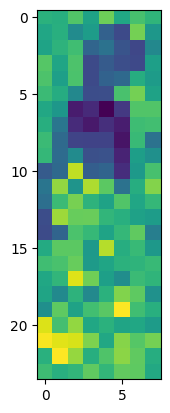

In [175]:
import matplotlib.pyplot as plt
 
plt.imshow(sim[15:18].t().mean(dim=-1).reshape(24, 8).cpu().numpy())

In [176]:
tokenizer.decode(sample['captions'][0].numpy())

'<|startoftext|>the man is wearing dark pants and a light shirt . he has dark hair . he is wearing shoes . <|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'

In [269]:
tokenizer.decode(sample['captions'][0].numpy()[20:21])

'shoes '

In [270]:
import cv2
ori_img = sample['images'][0].permute(1,2, 0).numpy()
attn_map = sim[20:21].t().mean(dim=-1).reshape(24, 8).cpu().numpy()

print(ori_img.shape)
print(attn_map.shape)

(384, 128, 3)
(24, 8)


In [271]:
import numpy as np

attention_map_normalized = (attn_map - np.min(attn_map)) / (np.max(attn_map) - np.min(attn_map))

attn_map = cv2.resize(attention_map_normalized, (ori_img.shape[1], ori_img.shape[0]))

In [272]:
ori_img = cv2.imread('data/CUHK-PEDES/imgs/' + train_loader.dataset.data[845][1])

In [273]:
ori_img = cv2.resize(ori_img, (128, 384))

In [274]:
attn_map_norm = (attn_map - np.min(attn_map)) / (np.max(attn_map) - np.min(attn_map))

In [275]:
colored_attention_map = cv2.applyColorMap((attn_map_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
colored_attention_map = cv2.resize(colored_attention_map, (ori_img.shape[1], ori_img.shape[0]))
overlay = cv2.addWeighted(ori_img, 0.5, colored_attention_map, 0.5, 0)


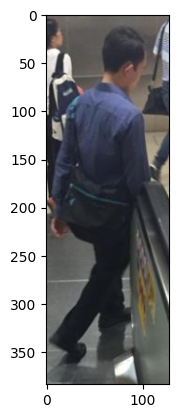

In [276]:
plt.imshow(cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB))

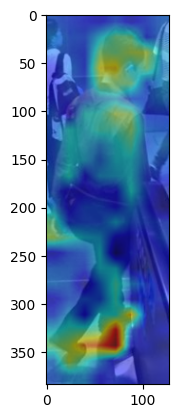

In [277]:
plt.imshow(overlay)

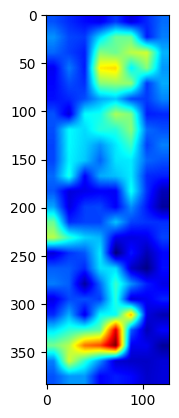

In [278]:
plt.imshow(colored_attention_map)

In [279]:
interest_tokens

NameError: name 'interest_tokens' is not defined

In [ ]:
test_tensor = torch.zeros((batch_size, 6, 77, 512))

for batch in range(16):
    #print(new_interest_tokens[batch])
    for i, temp_index in enumerate(interest_tokens[batch]):
        test_tensor[batch, i, temp_index] = 1
        
#test_tensor = test_tensor.repeat(1, 1, 1).reshape(batch_size, 6, 77, 512)

In [ ]:
test_tensor[0][0]

NameError: name 'test_tensor' is not defined

In [ ]:
res = repeat_cap * test_tensor

In [280]:
res[0][0]

NameError: name 'res' is not defined

In [281]:
mask = torch.ones_like(captions)

for i in range(captions.shape[1]):
    token = captions[:, i, :]
    is_prompt = torch.tensor([t in interest_tokens for t in token.tolist()])
    mask[:, i, :][~is_prompt] = 0

captions_filtered = captions * mask


NameError: name 'captions' is not defined

In [282]:
captions_filtered

NameError: name 'captions_filtered' is not defined

In [ ]:
with open("requirements.txt") as myFile:
  pkgs = myFile.read()
  pkgs = pkgs.splitlines()

  for pkg in pkgs:
      print(pkg.split('==')[0])
    #   myFile.write(pkg.split('==')[0]+"\n")

colorlog
ftfy
numpy
Pillow
Pillow
regex
spacy
tabulate
tensorboardX
termcolor
timm
torch
torchvision
tqdm
transformers
yacs
